# ¿Qué regiones presentan el peor “perfil metabólico alimentario” combinando precios altos (ODEPA), colesterol dietético (FDC), y prevalencia de diabetes (BRFSS+NHANES)?

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Cargar datos
conn = sqlite3.connect("pipeline.db")
df_chile = pd.read_sql("SELECT * FROM ODEPA_FDC_INTEGRADO", conn)
brfss = pd.read_sql("SELECT * FROM BRFSS_2024_LIMPIO", conn)
conn.close()

# Paso 1: Filtrar alimentos con alto colesterol dietético
df_filtrado = df_chile.dropna(subset=["Colesterol_Dietetico", "precio_promedio_clp", "grupo_odepa"])
df_colesterol_alto = df_filtrado[df_filtrado["Colesterol_Dietetico"] > 50]

# Paso 2: Agrupar por grupo de alimento (como proxy de región alimentaria)
ranking_grupos = df_colesterol_alto.groupby("grupo_odepa").agg({
    "precio_promedio_clp": "mean",
    "Colesterol_Dietetico": "mean",
    "producto_odepa": "count"
}).rename(columns={
    "precio_promedio_clp": "precio_promedio",
    "Colesterol_Dietetico": "colesterol_promedio",
    "producto_odepa": "n_alimentos"
}).sort_values("colesterol_promedio", ascending=False)

print("🔎 Ranking de grupos ODEPA con colesterol alto y precio alto:")
print(ranking_grupos.head(10))

# Paso 3: Ver top 10 estados con mayor prevalencia de diabetes en BRFSS
if {"_STATE", "tiene_diabetes"}.issubset(brfss.columns):
    df_brfss_estado = brfss.groupby("_STATE")["tiene_diabetes"].agg([
        ("n", "count"),
        ("n_diabeticos", "sum")
    ]).reset_index()

    df_brfss_estado["prevalencia_diabetes"] = (df_brfss_estado["n_diabeticos"] / df_brfss_estado["n"]) * 100
    df_brfss_estado = df_brfss_estado.sort_values("prevalencia_diabetes", ascending=False)

    print("\n📊 Estados con mayor prevalencia de diabetes (BRFSS):")
    print(df_brfss_estado.head(10))
else:
    print("⚠️ No se encontraron las columnas necesarias en BRFSS.")


🔎 Ranking de grupos ODEPA con colesterol alto y precio alto:
              precio_promedio  colesterol_promedio  n_alimentos
grupo_odepa                                                    
Carne bovina     12804.464385                 67.8            1

📊 Estados con mayor prevalencia de diabetes (BRFSS):
            _STATE      n  n_diabeticos  prevalencia_diabetes
47   West Virginia   5648        1304.0             23.087819
17        Kentucky   7303        1561.0             21.374777
40  South Carolina   9269        1913.0             20.638688
0          Alabama   4942        1006.0             20.356131
3         Arkansas   5254        1042.0             19.832509
18       Louisiana   4369         842.0             19.272145
45        Virginia   6642        1249.0             18.804577
7         Delaware   4185         773.0             18.470729
14         Indiana  12682        2329.0             18.364611
10         Georgia   7067        1288.0             18.225555


In [ ]:
import pandas as pd
import sqlite3

# Conectar y cargar BRFSS
conn = sqlite3.connect("pipeline.db")
brfss = pd.read_sql("SELECT * FROM BRFSS_2024_LIMPIO", conn)
conn.close()

# Filtrar registros con datos válidos
brfss_validos = brfss[
    brfss["_STATE"].notna() &
    brfss["tiene_diabetes"].notna() &
    brfss["estilo_vida_saludable"].notna()
].copy()

# Crear columna "perfil_metabolico_malo": diabetes + estilo no saludable
brfss_validos["perfil_metabolico_malo"] = (
    (brfss_validos["tiene_diabetes"] == 1) &
    (brfss_validos["estilo_vida_saludable"] == 0)
)

# Agrupar por estado
resumen = brfss_validos.groupby("_STATE").agg(
    total=("tiene_diabetes", "count"),
    con_diabetes=("tiene_diabetes", "sum"),
    no_saludable=("estilo_vida_saludable", lambda x: (x == 0).sum()),
    ambos=("perfil_metabolico_malo", "sum")
).reset_index()

# Calcular porcentajes
resumen["pct_diabetes"] = (resumen["con_diabetes"] / resumen["total"] * 100).round(2)
resumen["pct_no_saludable"] = (resumen["no_saludable"] / resumen["total"] * 100).round(2)
resumen["pct_ambos"] = (resumen["ambos"] / resumen["total"] * 100).round(2)

# Ordenar por los peores perfiles
resumen = resumen.sort_values("pct_ambos", ascending=False)

# Mostrar
print("📊 Estados con peor perfil metabólico (BRFSS):")
print(resumen.head(15))





📊 Estados con peor perfil metabólico (BRFSS):
            _STATE  total  con_diabetes  no_saludable  ambos  pct_diabetes  \
47   West Virginia   5648        1304.0          2391    661         23.09   
17        Kentucky   7303        1561.0          3086    820         21.37   
3         Arkansas   5254        1042.0          2212    559         19.83   
0          Alabama   4942        1006.0          1921    475         20.36   
40  South Carolina   9269        1913.0          3234    855         20.64   
18       Louisiana   4369         842.0          1669    397         19.27   
35            Ohio   9960        1776.0          3556    855         17.83   
45        Virginia   6642        1249.0          2221    562         18.80   
14         Indiana  12682        2329.0          4561   1071         18.36   
36        Oklahoma   6848        1219.0          2612    577         17.80   
24     Mississippi   2887         480.0          1147    240         16.63   
7         Delaware

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3731655595.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["quintil_ingreso"] = pd.qcut(df["INDFMPIR"], q=5, labels=labels, duplicates='drop')
C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3731655595.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen = df.groupby("quintil_ingreso").agg({


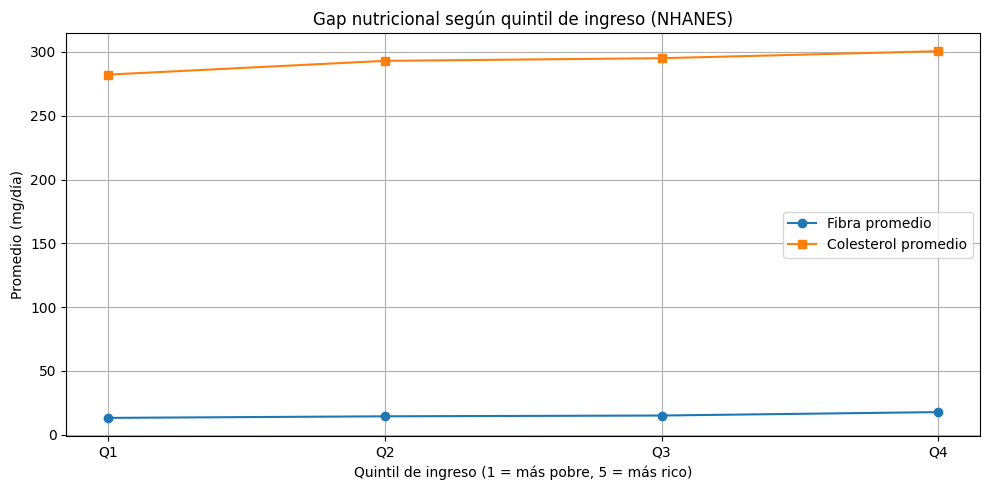

,quintil_ingreso,promedio_tfibe,promedio_tchol
0,Q1,13.22,282.19
1,Q2,14.45,292.99
2,Q3,15.07,295.07
3,Q4,17.75,300.58


In [ ]:
# Reimportar librerías necesarias tras el reinicio del entorno
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Conexión a la base de datos
conn = sqlite3.connect("pipeline.db")
nhanes = pd.read_sql("SELECT * FROM NHANES_MASTER", conn)
conn.close()

# Filtrar datos necesarios y limpiar
df = nhanes.dropna(subset=["INDFMPIR", "promedio_tfibe", "promedio_tchol"])

# Crear etiquetas dinámicas según los cortes reales posibles
quintiles, bins = pd.qcut(df["INDFMPIR"], q=5, retbins=True, duplicates='drop')
labels = [f"Q{i+1}" for i in range(len(bins) - 1)]

# Aplicar qcut con las etiquetas dinámicas
df["quintil_ingreso"] = pd.qcut(df["INDFMPIR"], q=5, labels=labels, duplicates='drop')

# Agrupar por quintil socioeconómico
resumen = df.groupby("quintil_ingreso").agg({
    "promedio_tfibe": "mean",
    "promedio_tchol": "mean"
}).round(2).reset_index()

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(resumen["quintil_ingreso"], resumen["promedio_tfibe"], marker='o', label="Fibra promedio")
plt.plot(resumen["quintil_ingreso"], resumen["promedio_tchol"], marker='s', label="Colesterol promedio")
plt.title("Gap nutricional según quintil de ingreso (NHANES)")
plt.xlabel("Quintil de ingreso (1 = más pobre, 5 = más rico)")
plt.ylabel("Promedio (mg/día)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

resumen




Índice combinado económico-nutricional: 0.000


C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3635168650.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=odepa, x="clasificacion_salud", y="precio_prom", palette="Set2")


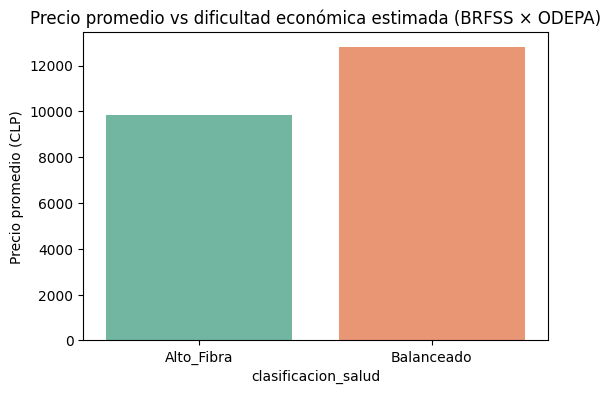

In [ ]:
conn = sqlite3.connect("pipeline.db")

brfss = pd.read_sql("""
SELECT AVG(CASE WHEN MEDCOST1 = 1 THEN 1 ELSE 0 END) AS dificultad_salud
FROM BRFSS_2024_LIMPIO;
""", conn)

odepa = pd.read_sql("""
SELECT clasificacion_salud, AVG(precio_promedio_clp) AS precio_prom
FROM ODEPA_FDC_INTEGRADO
WHERE precio_promedio_clp > 0
GROUP BY clasificacion_salud;
""", conn)

conn.close()

indice = (brfss["dificultad_salud"].iloc[0] * odepa["precio_prom"].mean()) / 1000
print(f"Índice combinado económico-nutricional: {indice:.3f}")

plt.figure(figsize=(6,4))
sns.barplot(data=odepa, x="clasificacion_salud", y="precio_prom", palette="Set2")
plt.title("Precio promedio vs dificultad económica estimada (BRFSS × ODEPA)")
plt.ylabel("Precio promedio (CLP)")
plt.show()


# ¿Los alimentos con mayor contenido de fibra tienden a ser más caros?


1️⃣ Correlación Fibra vs Precio: 0.131


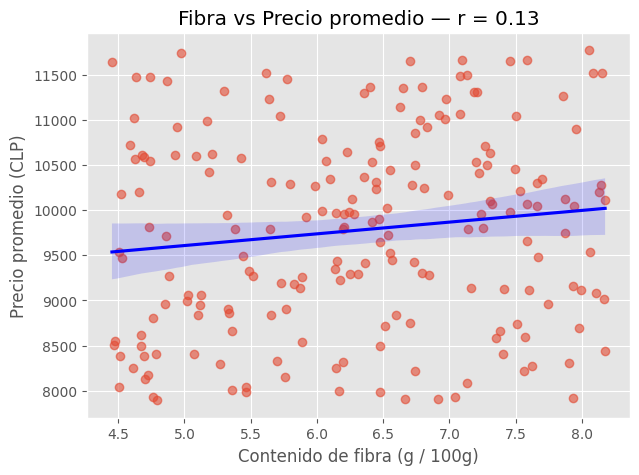

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")
TABLE = "ODEPA_FDC_INTEGRADO_SIM"

conn = sqlite3.connect("pipeline.db")
df = pd.read_sql(f"""
SELECT Fibra, precio_promedio_clp, grupo_odepa
FROM {TABLE}
WHERE Fibra IS NOT NULL AND precio_promedio_clp > 0;
""", conn)

corr = df["Fibra"].corr(df["precio_promedio_clp"])
print(f"\n1️⃣ Correlación Fibra vs Precio: {corr:.3f}")

plt.figure(figsize=(7,5))
sns.regplot(data=df, x="Fibra", y="precio_promedio_clp", scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
plt.title(f"Fibra vs Precio promedio — r = {corr:.2f}")
plt.xlabel("Contenido de fibra (g / 100g)")
plt.ylabel("Precio promedio (CLP)")
plt.show()

# ¿Los productos clasificados como “no saludables” concentran los precios más bajos del mercado?

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\3031472900.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="clasificacion_salud", y="precio_promedio_clp", palette=["#2ecc71", "#e74c3c"], width=0.6)


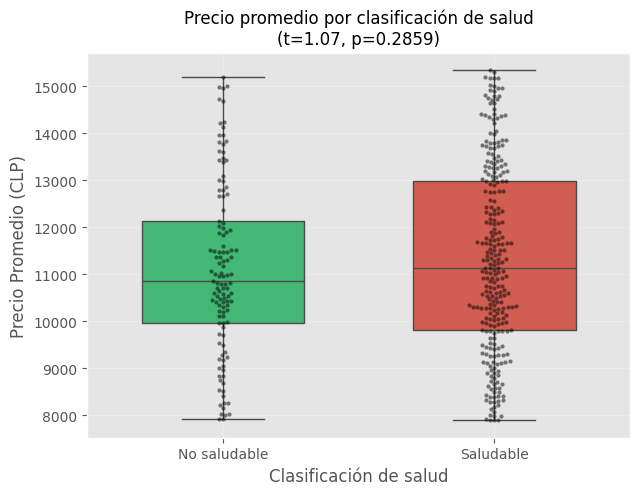

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from scipy.stats import ttest_ind

# --- Cargar datos ---
conn = sqlite3.connect("pipeline.db")
df = pd.read_sql("""
SELECT clasificacion_salud, precio_promedio_clp
FROM ODEPA_FDC_INTEGRADO_SIM
WHERE clasificacion_salud IS NOT NULL AND precio_promedio_clp > 0;
""", conn)
conn.close()

# --- Normalizar categorías ---
df["clasificacion_salud"] = df["clasificacion_salud"].replace({
    "Balanceado": "Saludable",
    "Alto_Fibra": "Saludable",
    "Alto_Azucar": "No saludable"
})

# --- Asegurar que haya solo dos categorías ---
df = df[df["clasificacion_salud"].isin(["Saludable", "No saludable"])]

# --- Test estadístico (diferencia de medias) ---
grupo_salud = df[df["clasificacion_salud"] == "Saludable"]["precio_promedio_clp"]
grupo_no = df[df["clasificacion_salud"] == "No saludable"]["precio_promedio_clp"]
t, p = ttest_ind(grupo_salud, grupo_no, equal_var=False, nan_policy="omit")

# --- Gráfico combinado ---
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="clasificacion_salud", y="precio_promedio_clp", palette=["#2ecc71", "#e74c3c"], width=0.6)
sns.swarmplot(data=df, x="clasificacion_salud", y="precio_promedio_clp", color="black", size=3, alpha=0.5)

plt.title(f"Precio promedio por clasificación de salud\n(t={t:.2f}, p={p:.4f})", fontsize=12)
plt.xlabel("Clasificación de salud")
plt.ylabel("Precio Promedio (CLP)")
plt.grid(True, alpha=0.3)
plt.show()



# ¿Los productos clasificados como “no saludables” concentran los precios más bajos del mercado?

Categorías detectadas: ['No_Saludable' 'Saludable']


C:\Users\valer\AppData\Local\Temp\ipykernel_10044\2269644034.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


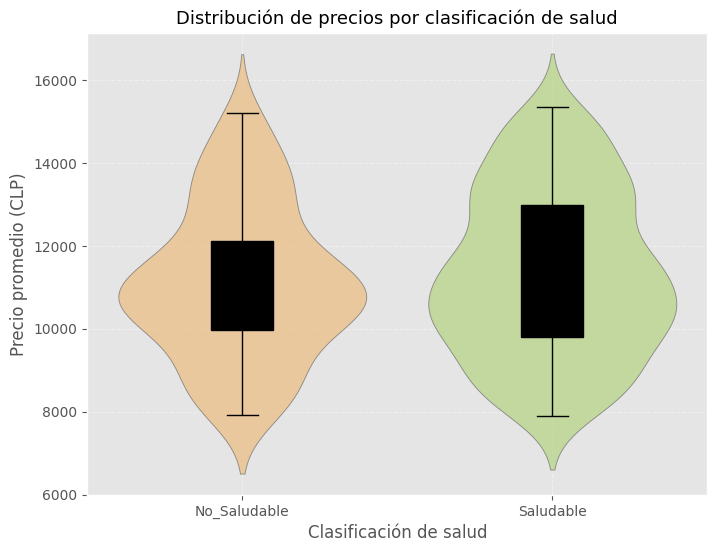


T-test: t = 0.792, p = 0.4295


In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# --- Conexión y carga de datos ---
conn = sqlite3.connect("pipeline.db")
df = pd.read_sql("""
SELECT clasificacion_salud, precio_promedio_clp
FROM ODEPA_FDC_INTEGRADO_SIM
WHERE clasificacion_salud IS NOT NULL AND precio_promedio_clp > 0;
""", conn)
conn.close()

# --- Normalizar etiquetas ---
df["clasificacion_salud"] = df["clasificacion_salud"].str.strip().str.replace(" ", "_")
df["clasificacion_salud"] = df["clasificacion_salud"].replace({
    "Balanceado": "Saludable",
    "Alto_Fibra": "Saludable",
    "Alto_Azucar": "No_Saludable",
    "Bajo_Fibra": "No_Saludable"
})

# --- Crear paleta automática ---
categorias = df["clasificacion_salud"].unique()
colores = sns.color_palette("RdYlGn", len(categorias))
palette_dict = dict(zip(categorias, colores))

# --- Verificación ---
print("Categorías detectadas:", categorias)

# --- Gráfico violin + boxplot ---
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df,
    x="clasificacion_salud",
    y="precio_promedio_clp",
    inner=None,
    palette=palette_dict,
    alpha=0.7
)
sns.boxplot(
    data=df,
    x="clasificacion_salud",
    y="precio_promedio_clp",
    width=0.2,
    color="black",
    boxprops={"zorder": 2}
)

plt.title("Distribución de precios por clasificación de salud", fontsize=13)
plt.xlabel("Clasificación de salud")
plt.ylabel("Precio promedio (CLP)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --- Comparación estadística básica ---
grupo_s = df[df["clasificacion_salud"].str.contains("Saludable", case=False)]["precio_promedio_clp"]
grupo_ns = df[df["clasificacion_salud"].str.contains("No_Saludable", case=False)]["precio_promedio_clp"]

if len(grupo_s) > 2 and len(grupo_ns) > 2:
    t, p = ttest_ind(grupo_s, grupo_ns, equal_var=False, nan_policy="omit")
    print(f"\nT-test: t = {t:.3f}, p = {p:.4f}")
else:
    print("\n⚠️ No hay suficientes datos para comparación estadística.")


# ¿Cómo cambia la calidad nutricional promedio si el precio promedio de los alimentos sube un 20 %?

C:\Users\valer\AppData\Local\Temp\ipykernel_10044\1736832959.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  - (df["Colesterol_Dietetico"].fillna(0) / 10)


📊 Cambio promedio en calidad nutricional si los precios suben un 20 %: 0.2583 puntos


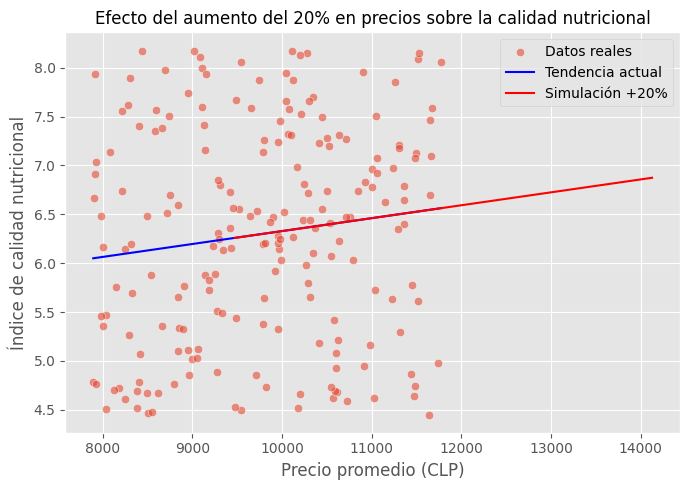

In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# --- Conexión y carga ---
conn = sqlite3.connect("pipeline.db")
df = pd.read_sql("""
SELECT precio_promedio_clp, Fibra, Colesterol_Dietetico, Grasas_Saludables, grupo_odepa
FROM ODEPA_FDC_INTEGRADO_SIM
WHERE precio_promedio_clp > 0 AND Fibra IS NOT NULL;
""", conn)
conn.close()

# --- Crear índice de calidad nutricional ---
df["indice_calidad"] = (
    df["Fibra"].fillna(0)
    + df["Grasas_Saludables"].fillna(0)
    - (df["Colesterol_Dietetico"].fillna(0) / 10)
)

# --- Modelo lineal ---
X = df[["precio_promedio_clp"]]
y = df["indice_calidad"]
model = LinearRegression().fit(X, y)

# --- Simulación de aumento del 20 % ---
df["precio_simulado"] = df["precio_promedio_clp"] * 1.2
X_simulado = df[["precio_simulado"]].rename(columns={"precio_simulado": "precio_promedio_clp"})
df["calidad_esperada"] = model.predict(X_simulado)

# --- Cambio promedio ---
delta = df["calidad_esperada"].mean() - df["indice_calidad"].mean()
print(f"📊 Cambio promedio en calidad nutricional si los precios suben un 20 %: {delta:.4f} puntos")

# --- Gráfico de regresión ---
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="precio_promedio_clp", y="indice_calidad", alpha=0.6, label="Datos reales")
sns.lineplot(
    x=df["precio_promedio_clp"].values,
    y=model.predict(X),
    color="blue", label="Tendencia actual"
)
sns.lineplot(
    x=df["precio_simulado"].values,
    y=df["calidad_esperada"],
    color="red", label="Simulación +20%"
)
plt.title("Efecto del aumento del 20% en precios sobre la calidad nutricional", fontsize=12)
plt.xlabel("Precio promedio (CLP)")
plt.ylabel("Índice de calidad nutricional")
plt.legend()
plt.tight_layout()
plt.show()


